In [2]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

In [8]:
data = np.genfromtxt('processed_cases.csv', delimiter=',')
np.random.shuffle(data)
train_data = data[:100, :4]
train_labels = data[:100, 5]
test_data = data[322181:, :4]
test_labels = data[322181:, 5]

In [9]:
model = keras.Sequential([
    keras.layers.Input(shape=(4,)),
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(8, activation='tanh'),
    keras.layers.Dense(8, activation='tanh'),
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])

Epoch 1/50
4/4 [==============================] - 0s 3ms/step - loss: 2936.8613 - mean_squared_error: 2936.8613
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 2934.8765 - mean_squared_error: 2934.8765
Epoch 3/50
4/4 [==============================] - 0s 3ms/step - loss: 2933.1687 - mean_squared_error: 2933.1687
Epoch 4/50
4/4 [==============================] - 0s 3ms/step - loss: 2931.5281 - mean_squared_error: 2931.5281
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 2929.6003 - mean_squared_error: 2929.6003
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 2928.0681 - mean_squared_error: 2928.0681
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 2926.6699 - mean_squared_error: 2926.6699
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 2924.6943 - mean_squared_error: 2924.6943
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 2923.0974 - mean_squared_error: 29

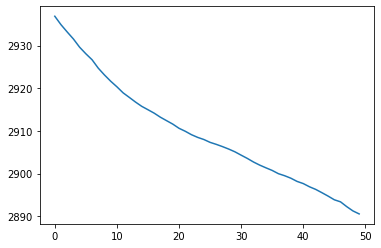

In [10]:
history = model.fit(train_data, train_labels, epochs=50)
plt.plot(history.history['mean_squared_error'])
plt.savefig('graph.png')

In [56]:
test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=2)

1563/1563 - 1s - loss: 15772.7607 - mean_squared_error: 15772.7607
